### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [ ]:
def the_preprocess(df):
    # make everything lowercase
    df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    #lematizer = nltk.WordNetLemmatizer()
    #df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    #stemmer = nltk.PorterStemmer()
    #df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [3]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)
val_dataset = preprocess(val_dataset)

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [4]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [6]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [7]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x177743d90>, 'text': <torchtext.data.field.Field object at 0x177743df0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [8]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [9]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [10]:
import random
import os
import numpy as np

emb = 'fasttext'

if emb == 'fasttext':

    EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

elif emb == 'glove':

    EMBEDDING_PATH = "data/glove.6B.300d.txt"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)


elif emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

Loading pre-trained embeddings
Initializing embedding matrix
torch.Size([9135, 300])


In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [12]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)

        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [13]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [14]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec & glove
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 70
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Total training loss: 35.392414689064026
Training performance: (0.40295, 0.40295, 0.40295, None)
Total development loss: 2.5799389481544495
Development performance: (0.6926, 0.6926, 0.6926, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


Total training loss: 18.72599047422409
Training performance: (0.7219, 0.7219, 0.7219, None)
Total development loss: 2.2425415217876434
Development performance: (0.699, 0.699, 0.699, None)
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


Total training loss: 14.73447397351265
Training performance: (0.759775, 0.759775, 0.759775, None)
Total development loss: 2.050752341747284
Development performance: (0.7342, 0.7342, 0.7342, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Total training loss: 12.758317813277245
Training performance: (0.774675, 0.774675, 0.774675, None)
Total development loss: 1.9445213079452515
Development performance: (0.7298, 0.7298, 0.7298, None)
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:04<00:00,  7.68it/s]


Total training loss: 11.63116604089737
Training performance: (0.793225, 0.793225, 0.793225, None)
Total development loss: 1.9847281873226166
Development performance: (0.6932, 0.6932, 0.6932, None)


Epoch 5: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Total training loss: 10.406424194574356
Training performance: (0.805725, 0.805725, 0.805725, None)
Total development loss: 1.8802679479122162
Development performance: (0.7698, 0.7698, 0.7698, None)
Saving model.


Epoch 6: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Total training loss: 9.619245991110802
Training performance: (0.813275, 0.813275, 0.813275, None)
Total development loss: 1.7861899137496948
Development performance: (0.772, 0.772, 0.772, None)
Saving model.


Epoch 7: 100%|██████████| 34/34 [00:04<00:00,  7.35it/s]


Total training loss: 8.554245814681053
Training performance: (0.830925, 0.830925, 0.830925, None)
Total development loss: 1.9541434347629547
Development performance: (0.7142, 0.7142, 0.7142, None)


Epoch 8: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Total training loss: 7.967615723609924
Training performance: (0.836425, 0.836425, 0.836425, None)
Total development loss: 1.8420858681201935
Development performance: (0.7956, 0.7956, 0.7956, None)
Saving model.


Epoch 9: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Total training loss: 7.124230057001114
Training performance: (0.8521, 0.8521, 0.8521, None)
Total development loss: 1.8376918733119965
Development performance: (0.7992, 0.7992, 0.7992, None)
Saving model.


Epoch 10: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Total training loss: 6.3539725467562675
Training performance: (0.861375, 0.861375, 0.861375, None)
Total development loss: 1.9091020226478577
Development performance: (0.8006, 0.8006, 0.8006, None)


Epoch 11: 100%|██████████| 34/34 [00:04<00:00,  8.30it/s]


Total training loss: 5.758236363530159
Training performance: (0.87095, 0.87095, 0.87095, None)
Total development loss: 1.908553570508957
Development performance: (0.7912, 0.7912, 0.7912, None)


Epoch 12: 100%|██████████| 34/34 [00:04<00:00,  8.36it/s]


Total training loss: 5.4631263837218285
Training performance: (0.874125, 0.874125, 0.874125, None)
Total development loss: 1.9793870449066162
Development performance: (0.823, 0.823, 0.823, None)
Saving model.


Epoch 13: 100%|██████████| 34/34 [00:04<00:00,  7.48it/s]


Total training loss: 4.573168575763702
Training performance: (0.89055, 0.89055, 0.89055, None)
Total development loss: 1.9577555358409882
Development performance: (0.8202, 0.8202, 0.8202, None)


Epoch 14: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Total training loss: 4.409763015806675
Training performance: (0.8959, 0.8959, 0.8959, None)
Total development loss: 2.2598263025283813
Development performance: (0.7864, 0.7864, 0.7864, None)


Epoch 15: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


Total training loss: 4.393776297569275
Training performance: (0.893125, 0.893125, 0.893125, None)
Total development loss: 2.1652751863002777
Development performance: (0.8096, 0.8096, 0.8096, None)


Epoch 16: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


Total training loss: 4.054666507989168
Training performance: (0.89805, 0.89805, 0.89805, None)
Total development loss: 2.1706956326961517
Development performance: (0.8248, 0.8248, 0.8248, None)


Epoch 17: 100%|██████████| 34/34 [00:04<00:00,  7.37it/s]


Total training loss: 3.3185991048812866
Training performance: (0.917525, 0.917525, 0.917525, None)
Total development loss: 2.268394559621811
Development performance: (0.864, 0.864, 0.864, None)
Saving model.


Epoch 18: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Total training loss: 3.704475622624159
Training performance: (0.901975, 0.901975, 0.901975, None)
Total development loss: 2.2007787227630615
Development performance: (0.8394, 0.8394, 0.8394, None)


Epoch 19: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Total training loss: 3.397845920175314
Training performance: (0.915275, 0.915275, 0.915275, None)
Total development loss: 2.349924385547638
Development performance: (0.8462, 0.8462, 0.8462, None)


Epoch 20: 100%|██████████| 34/34 [00:05<00:00,  6.64it/s]


Total training loss: 2.6212800927460194
Training performance: (0.930575, 0.930575, 0.930575, None)
Total development loss: 2.9760660529136658
Development performance: (0.8834, 0.8834, 0.8834, None)
Saving model.


Epoch 21: 100%|██████████| 34/34 [00:04<00:00,  6.95it/s]


Total training loss: 2.6825224719941616
Training performance: (0.93185, 0.93185, 0.93185, None)
Total development loss: 2.6957974433898926
Development performance: (0.8502, 0.8502, 0.8502, None)


Epoch 22: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]


Total training loss: 2.032175788655877
Training performance: (0.94705, 0.94705, 0.94705, None)
Total development loss: 2.7465239763259888
Development performance: (0.8598, 0.8598, 0.8598, None)


Epoch 23: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Total training loss: 1.741634663194418
Training performance: (0.95205, 0.95205, 0.95205, None)
Total development loss: 3.3552150428295135
Development performance: (0.8872, 0.8872, 0.8872, None)
Saving model.


Epoch 24: 100%|██████████| 34/34 [00:05<00:00,  6.18it/s]


Total training loss: 1.6095133610069752
Training performance: (0.9588, 0.9588, 0.9588, None)
Total development loss: 3.1345724165439606
Development performance: (0.8726, 0.8726, 0.8726, None)


Epoch 25: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Total training loss: 1.3813468227162957
Training performance: (0.9635, 0.9635, 0.9635, None)
Total development loss: 3.3928142786026
Development performance: (0.8728, 0.8728, 0.8728, None)


Epoch 26: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Total training loss: 1.1889613680541515
Training performance: (0.967975, 0.967975, 0.967975, None)
Total development loss: 3.623875916004181
Development performance: (0.8756, 0.8756, 0.8756, None)


Epoch 27: 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Total training loss: 1.1934564597904682
Training performance: (0.966775, 0.966775, 0.966775, None)
Total development loss: 3.6892908215522766
Development performance: (0.8742, 0.8742, 0.8742, None)


Epoch 28: 100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Total training loss: 1.2792662400752306
Training performance: (0.96645, 0.96645, 0.96645, None)
Total development loss: 3.6516225934028625
Development performance: (0.8782, 0.8782, 0.8782, None)


Epoch 29: 100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Total training loss: 1.0301215220242739
Training performance: (0.97455, 0.97455, 0.97455, None)
Total development loss: 3.450839400291443
Development performance: (0.8592, 0.8592, 0.8592, None)


Epoch 30: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Total training loss: 0.9260120308026671
Training performance: (0.9756, 0.9756, 0.9756, None)
Total development loss: 3.8560178875923157
Development performance: (0.8796, 0.8796, 0.8796, None)


Epoch 31: 100%|██████████| 34/34 [00:05<00:00,  6.00it/s]


Total training loss: 0.9973677573725581
Training performance: (0.97205, 0.97205, 0.97205, None)
Total development loss: 3.6911502182483673
Development performance: (0.873, 0.873, 0.873, None)


Epoch 32: 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


Total training loss: 1.0568552855402231
Training performance: (0.972375, 0.972375, 0.972375, None)
Total development loss: 3.735735446214676
Development performance: (0.8802, 0.8802, 0.8802, None)


Epoch 33: 100%|██████████| 34/34 [00:04<00:00,  7.30it/s]


Total training loss: 0.7159683024510741
Training performance: (0.9803, 0.9803, 0.9803, None)
Total development loss: 4.46711939573288
Development performance: (0.893, 0.893, 0.893, None)


Epoch 34: 100%|██████████| 34/34 [00:05<00:00,  6.79it/s]


Total training loss: 0.5342136397957802
Training performance: (0.986175, 0.986175, 0.986175, None)
Total development loss: 4.692116737365723
Development performance: (0.8864, 0.8864, 0.8864, None)


Epoch 35: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Total training loss: 0.4244922960642725
Training performance: (0.989475, 0.989475, 0.989475, None)
Total development loss: 4.65263557434082
Development performance: (0.8884, 0.8884, 0.8884, None)


Epoch 36: 100%|██████████| 34/34 [00:04<00:00,  6.84it/s]


Total training loss: 0.3814628953114152
Training performance: (0.98995, 0.98995, 0.98995, None)
Total development loss: 4.8156720995903015
Development performance: (0.8796, 0.8796, 0.8796, None)


Epoch 37: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Total training loss: 0.3577737919986248
Training performance: (0.99115, 0.99115, 0.99115, None)
Total development loss: 5.199984312057495
Development performance: (0.8848, 0.8848, 0.8848, None)


Epoch 38: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Total training loss: 0.542128452565521
Training performance: (0.984775, 0.984775, 0.984775, None)
Total development loss: 4.5565802454948425
Development performance: (0.8808, 0.8808, 0.8808, None)


Epoch 39: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Total training loss: 0.5277434438467026
Training performance: (0.986725, 0.986725, 0.986725, None)
Total development loss: 4.8064024448394775
Development performance: (0.8832, 0.8832, 0.8832, None)


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  6.74it/s]


Total training loss: 0.5420421320013702
Training performance: (0.985625, 0.985625, 0.985625, None)
Total development loss: 4.905134379863739
Development performance: (0.8836, 0.8836, 0.8836, None)


Epoch 41: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Total training loss: 0.5680480957962573
Training performance: (0.986825, 0.986825, 0.986825, None)
Total development loss: 4.556818664073944
Development performance: (0.8762, 0.8762, 0.8762, None)


Epoch 42: 100%|██████████| 34/34 [00:05<00:00,  6.75it/s]


Total training loss: 0.37934650178067386
Training performance: (0.991325, 0.991325, 0.991325, None)
Total development loss: 4.300981879234314
Development performance: (0.8766, 0.8766, 0.8766, None)


Epoch 43: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Total training loss: 0.3238329233136028
Training performance: (0.99185, 0.99185, 0.99185, None)
Total development loss: 5.141140520572662
Development performance: (0.8796, 0.8796, 0.8796, None)


Epoch 44: 100%|██████████| 34/34 [00:05<00:00,  6.75it/s]


Total training loss: 0.2620882159098983
Training performance: (0.99285, 0.99285, 0.99285, None)
Total development loss: 6.248545527458191
Development performance: (0.8966, 0.8966, 0.8966, None)


Epoch 45: 100%|██████████| 34/34 [00:04<00:00,  7.37it/s]


Total training loss: 0.24884821427986026
Training performance: (0.99425, 0.99425, 0.99425, None)
Total development loss: 6.236972212791443
Development performance: (0.897, 0.897, 0.897, None)


Epoch 46: 100%|██████████| 34/34 [00:04<00:00,  6.91it/s]


Total training loss: 0.2625348484143615
Training performance: (0.993125, 0.993125, 0.993125, None)
Total development loss: 5.587915360927582
Development performance: (0.8852, 0.8852, 0.8852, None)


Epoch 47: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 0.26183820189908147
Training performance: (0.9926, 0.9926, 0.9926, None)
Total development loss: 6.059037685394287
Development performance: (0.8968, 0.8968, 0.8968, None)


Epoch 48: 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


Total training loss: 0.2130005364306271
Training performance: (0.99535, 0.99535, 0.99535, None)
Total development loss: 5.255974113941193
Development performance: (0.884, 0.884, 0.884, None)


Epoch 49: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Total training loss: 0.4476106498623267
Training performance: (0.98795, 0.98795, 0.98795, None)
Total development loss: 4.351088106632233
Development performance: (0.8612, 0.8612, 0.8612, None)


Epoch 50: 100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Total training loss: 0.5565261275041848
Training performance: (0.984575, 0.984575, 0.984575, None)
Total development loss: 4.736869752407074
Development performance: (0.8738, 0.8738, 0.8738, None)


Epoch 51: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Total training loss: 0.31372399698011577
Training performance: (0.9917, 0.9917, 0.9917, None)
Total development loss: 5.523014843463898
Development performance: (0.8904, 0.8904, 0.8904, None)


Epoch 52: 100%|██████████| 34/34 [00:05<00:00,  6.80it/s]


Total training loss: 0.24281271372456104
Training performance: (0.994725, 0.994725, 0.994725, None)
Total development loss: 5.907220125198364
Development performance: (0.8932, 0.8932, 0.8932, None)


Epoch 53: 100%|██████████| 34/34 [00:04<00:00,  7.34it/s]


Total training loss: 0.16010872123297304
Training performance: (0.996875, 0.996875, 0.996875, None)
Total development loss: 5.830480635166168
Development performance: (0.8894, 0.8894, 0.8894, None)


Epoch 54: 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


Total training loss: 0.12246986862737685
Training performance: (0.9978, 0.9978, 0.9978, None)
Total development loss: 6.14190286397934
Development performance: (0.898, 0.898, 0.898, None)


Epoch 55: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Total training loss: 0.09222115488955751
Training performance: (0.9985, 0.9985, 0.9985, None)
Total development loss: 6.256701946258545
Development performance: (0.8916, 0.8916, 0.8916, None)


Epoch 56: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Total training loss: 0.08205203362740576
Training performance: (0.998525, 0.998525, 0.998525, None)
Total development loss: 6.640747666358948
Development performance: (0.896, 0.896, 0.896, None)


Epoch 57: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


Total training loss: 0.06751919246744365
Training performance: (0.998825, 0.998825, 0.998825, None)
Total development loss: 6.488456070423126
Development performance: (0.8942, 0.8942, 0.8942, None)


Epoch 58: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Total training loss: 0.06177984509849921
Training performance: (0.999125, 0.999125, 0.999125, None)
Total development loss: 6.763927340507507
Development performance: (0.8954, 0.8954, 0.8954, None)


Epoch 59: 100%|██████████| 34/34 [00:05<00:00,  6.76it/s]


Total training loss: 0.0536094672861509
Training performance: (0.999275, 0.999275, 0.999275, None)
Total development loss: 6.847843289375305
Development performance: (0.8956, 0.8956, 0.8956, None)


Epoch 60: 100%|██████████| 34/34 [00:04<00:00,  6.82it/s]


Total training loss: 0.04801679588854313
Training performance: (0.9994, 0.9994, 0.9994, None)
Total development loss: 7.473007678985596
Development performance: (0.896, 0.896, 0.896, None)


Epoch 61: 100%|██████████| 34/34 [00:04<00:00,  7.42it/s]


Total training loss: 0.041631550062447786
Training performance: (0.999575, 0.999575, 0.999575, None)
Total development loss: 7.2200517654418945
Development performance: (0.8954, 0.8954, 0.8954, None)


Epoch 62: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 0.04230538348201662
Training performance: (0.999325, 0.999325, 0.999325, None)
Total development loss: 7.543216228485107
Development performance: (0.8956, 0.8956, 0.8956, None)


Epoch 63: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Total training loss: 0.03852197853848338
Training performance: (0.9996, 0.9996, 0.9996, None)
Total development loss: 7.6279571652412415
Development performance: (0.8988, 0.8988, 0.8988, None)


Epoch 64: 100%|██████████| 34/34 [00:05<00:00,  6.71it/s]


Total training loss: 0.037672465085051954
Training performance: (0.99945, 0.99945, 0.99945, None)
Total development loss: 7.471920311450958
Development performance: (0.8978, 0.8978, 0.8978, None)


Epoch 65: 100%|██████████| 34/34 [00:04<00:00,  7.57it/s]


Total training loss: 0.043368518294300884
Training performance: (0.999275, 0.999275, 0.999275, None)
Total development loss: 7.589651584625244
Development performance: (0.8946, 0.8946, 0.8946, None)


Epoch 66: 100%|██████████| 34/34 [00:04<00:00,  7.32it/s]


Total training loss: 0.041077723901253194
Training performance: (0.99945, 0.99945, 0.99945, None)
Total development loss: 7.572110056877136
Development performance: (0.8952, 0.8952, 0.8952, None)


Epoch 67: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Total training loss: 0.03442049180739559
Training performance: (0.999575, 0.999575, 0.999575, None)
Total development loss: 7.7598336935043335
Development performance: (0.8966, 0.8966, 0.8966, None)


Epoch 68: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Total training loss: 0.028972914471523836
Training performance: (0.99965, 0.99965, 0.99965, None)
Total development loss: 7.8118391036987305
Development performance: (0.9002, 0.9002, 0.9002, None)


Epoch 69: 100%|██████████| 34/34 [00:04<00:00,  7.32it/s]


Total training loss: 0.027072568336734548
Training performance: (0.999675, 0.999675, 0.999675, None)
Total development loss: 8.142091989517212
Development performance: (0.8972, 0.8972, 0.8972, None)


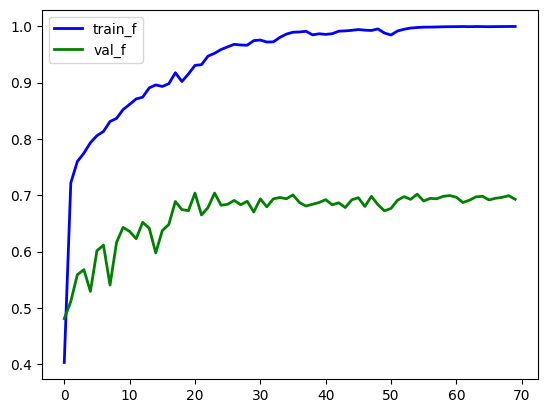

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [16]:
%load_ext tensorboard

In [17]:
OUTPUT_PATH = "model_saves/bilstmtagger"

In [18]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(9135, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [19]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.45      0.71      0.55       270
        I-LF       0.60      0.73      0.66       288
        B-LF       0.48      0.57      0.52       150
         B-O       0.96      0.90      0.93      4292

    accuracy                           0.87      5000
   macro avg       0.62      0.73      0.67      5000
weighted avg       0.90      0.87      0.88      5000



In [20]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")